In [1]:
import sys
sys.dont_write_bytecode = True
import os
from itertools import product
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from src.models.train_model import BTCForecasting

import pickle
import gc

from src.utils.utils import *
from src.utils.constants import *
from src.visualization.visualize import *

In [2]:
# Classifiers

classifiers = {
    'RFC_balanced_subsample': RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced_subsample', n_jobs=-1),
}

In [3]:
# Training params

view_params = {
    'candles': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 3,
        'aggresive_elimination': False,
        'n_splits': 5,
        'classifier__max_depth': range(1, 8),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50],
    },
    'orderbook': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 3,
        'aggresive_elimination': False,
        'n_splits': 5,
        'classifier__max_depth': range(1, 8),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50],
    },
    'unified': {
        'use_smoteenn': False,
        'feature_selection': 'sfm',
        'factor': 3,
        'aggresive_elimination': False,
        'n_splits': 5,
        'classifier__max_depth': range(1, 8),
        'classifier__min_samples_leaf': range(1, 10, 1),
        'classifier__min_samples_split': range(2, 20, 2),
        'classifier__max_leaf_nodes': [10, 20, 30, 40, 50],
    }
}

In [ ]:
# Import data

data = {
    (exchange, data_type): pd.read_parquet(
        os.path.join(INTERIM_DATA_PATH, f'{exchange}_{data_type}_data.parquet')
    )
    for exchange, data_type in product(EXCHANGES, DATA_TYPES)
}
data[(ALL, UNIFIED)] = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, f'{ALL}_{UNIFIED}_data.parquet'))

ground_truth = pd.read_parquet(os.path.join(INTERIM_DATA_PATH, 'ground_truth_data.parquet'))

In [ ]:
# Training

model_params = {}

for (name, classifier) in classifiers.items():
    for (exchange, data_type), df in data.items():
        params = view_params[data_type]

        use_smoteenn = params['use_smoteenn']
        factor = params['factor']
        aggressive_elimination = params['aggresive_elimination']
        n_splits = params['n_splits']
        
        print(f"\nStarting training {name} model for {exchange} - {data_type}")

        btcf = BTCForecasting(
            df, 
            ground_truth,
            n_splits=n_splits,
            smoteenn=use_smoteenn,
            pca_variance_threshold=PCA_VARIANCE_THRESHOLD,
            feature_selection=params['feature_selection'],
        )

        model_params = {k: v for k, v in params.items() if k.startswith('classifier__')}

        btcf.train(classifier, model_params, factor=factor, aggressive_elimination=aggressive_elimination, verbose=0)

        save_model(btcf, name, exchange, data_type)
                
        del(btcf)
        gc.collect()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Best RFC_balanced_subsample model for BINANCE - candles
CV results: dict_keys(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier__max_depth', 'param_classifier__max_leaf_nodes', 'param_classifier__min_samples_leaf', 'param_classifier__min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
CV results: 4253


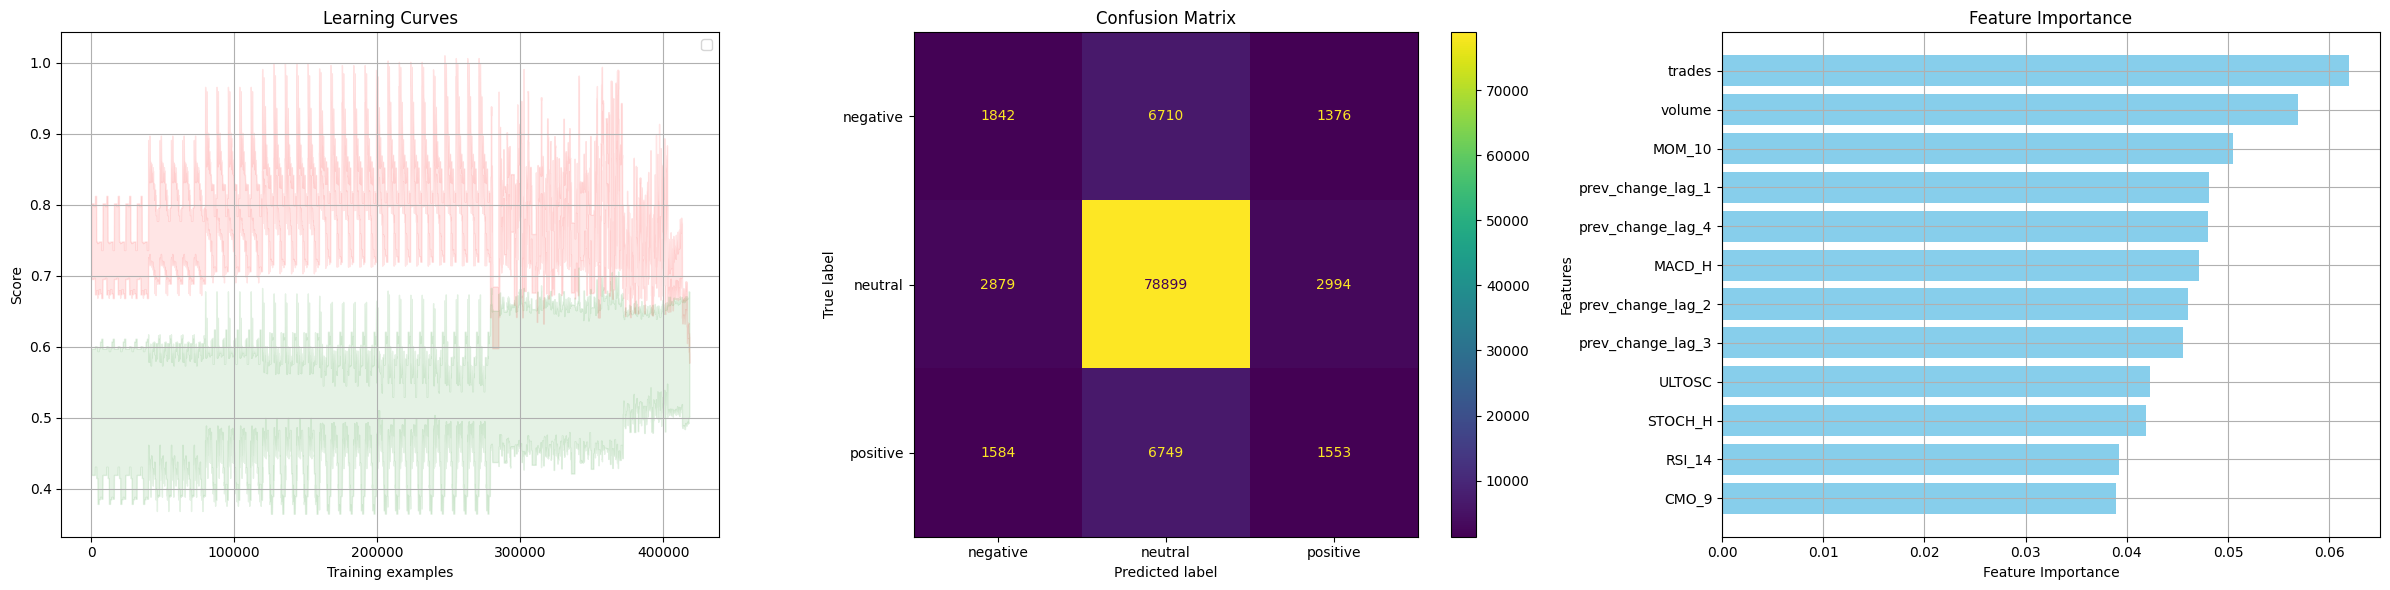

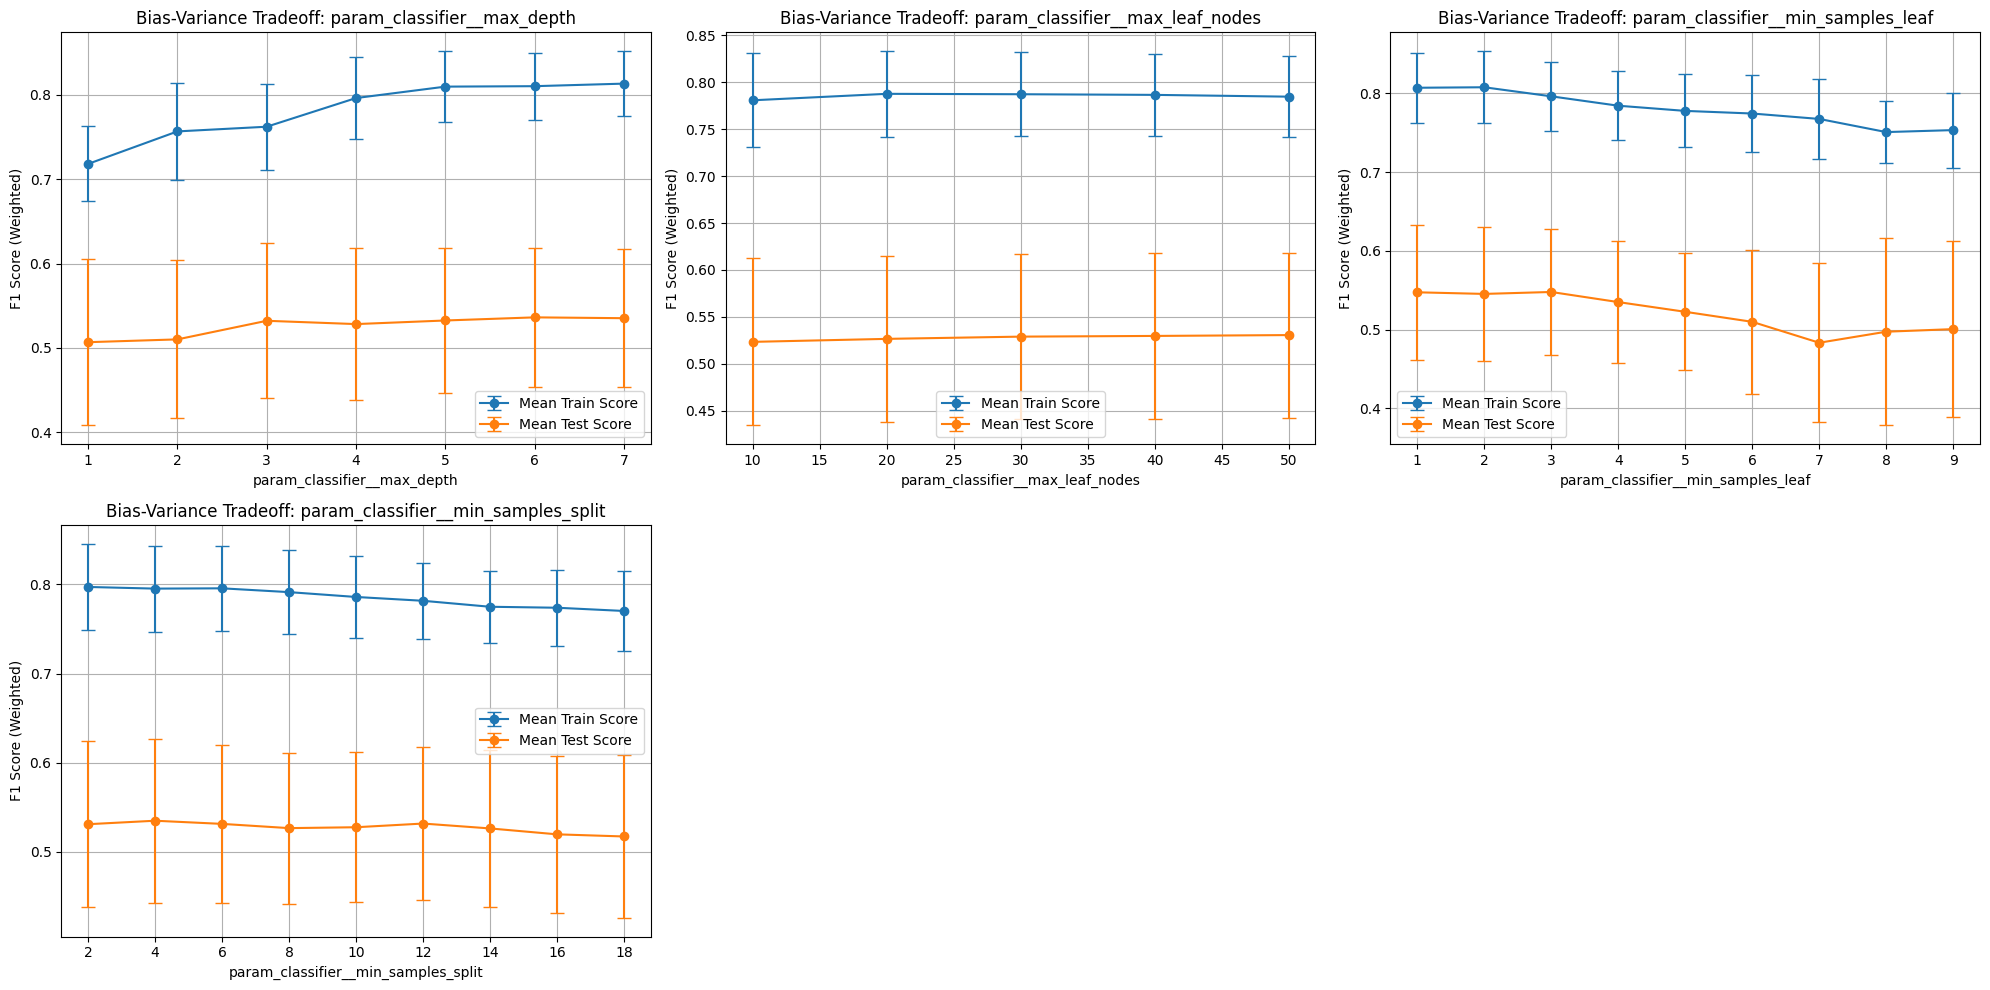

522930


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Best RFC_balanced_subsample model for BINANCE - orderbook
CV results: dict_keys(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier__max_depth', 'param_classifier__max_leaf_nodes', 'param_classifier__min_samples_leaf', 'param_classifier__min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
CV results: 4253


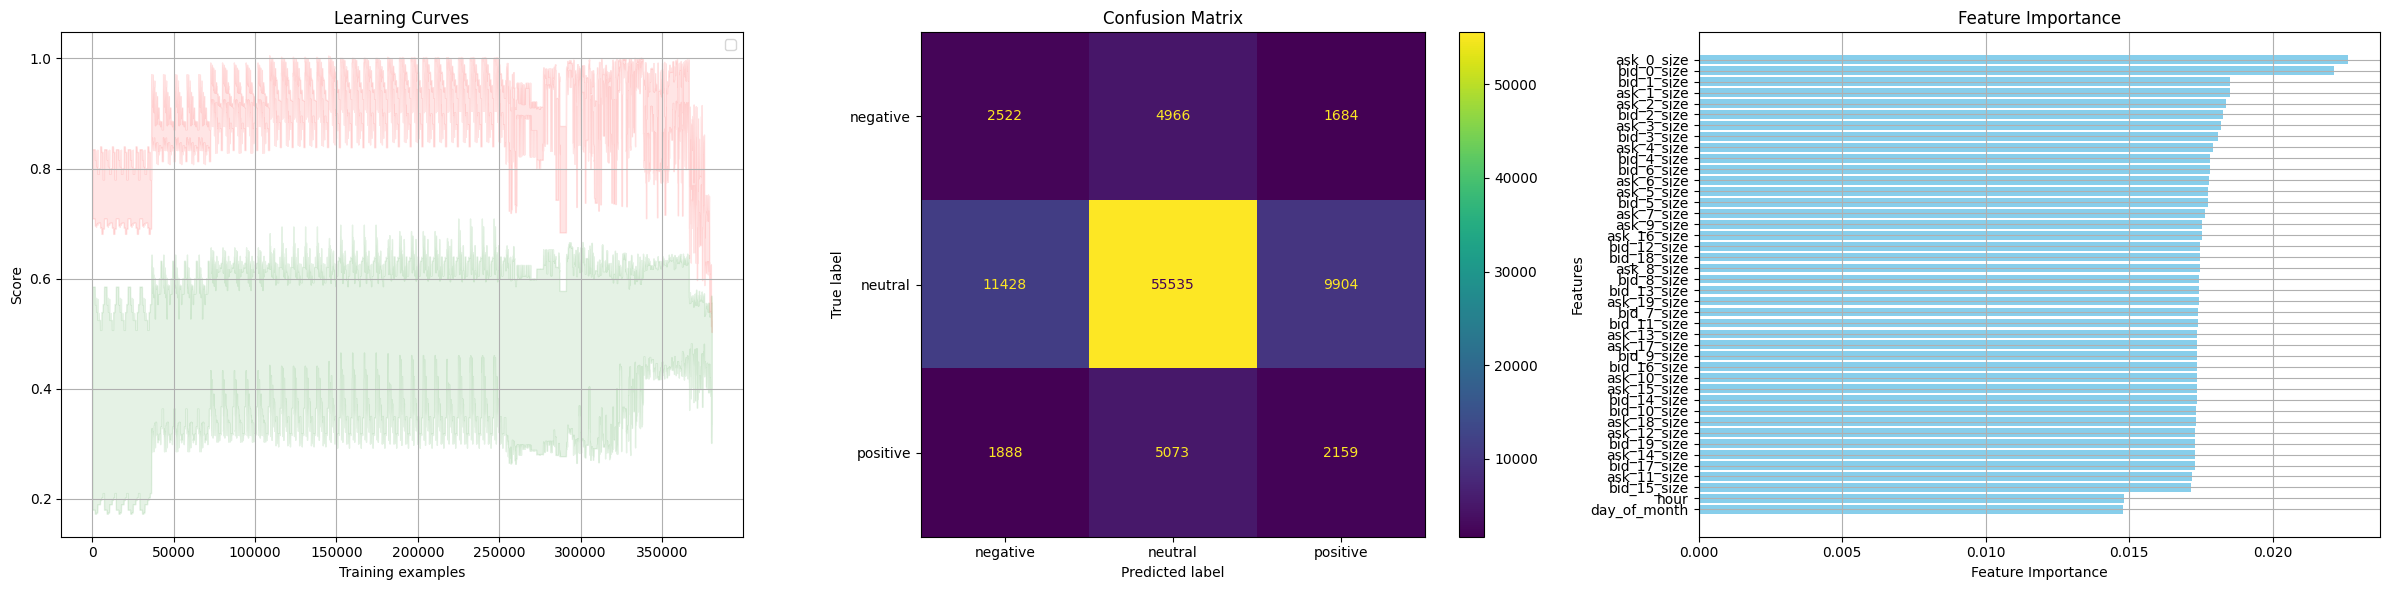

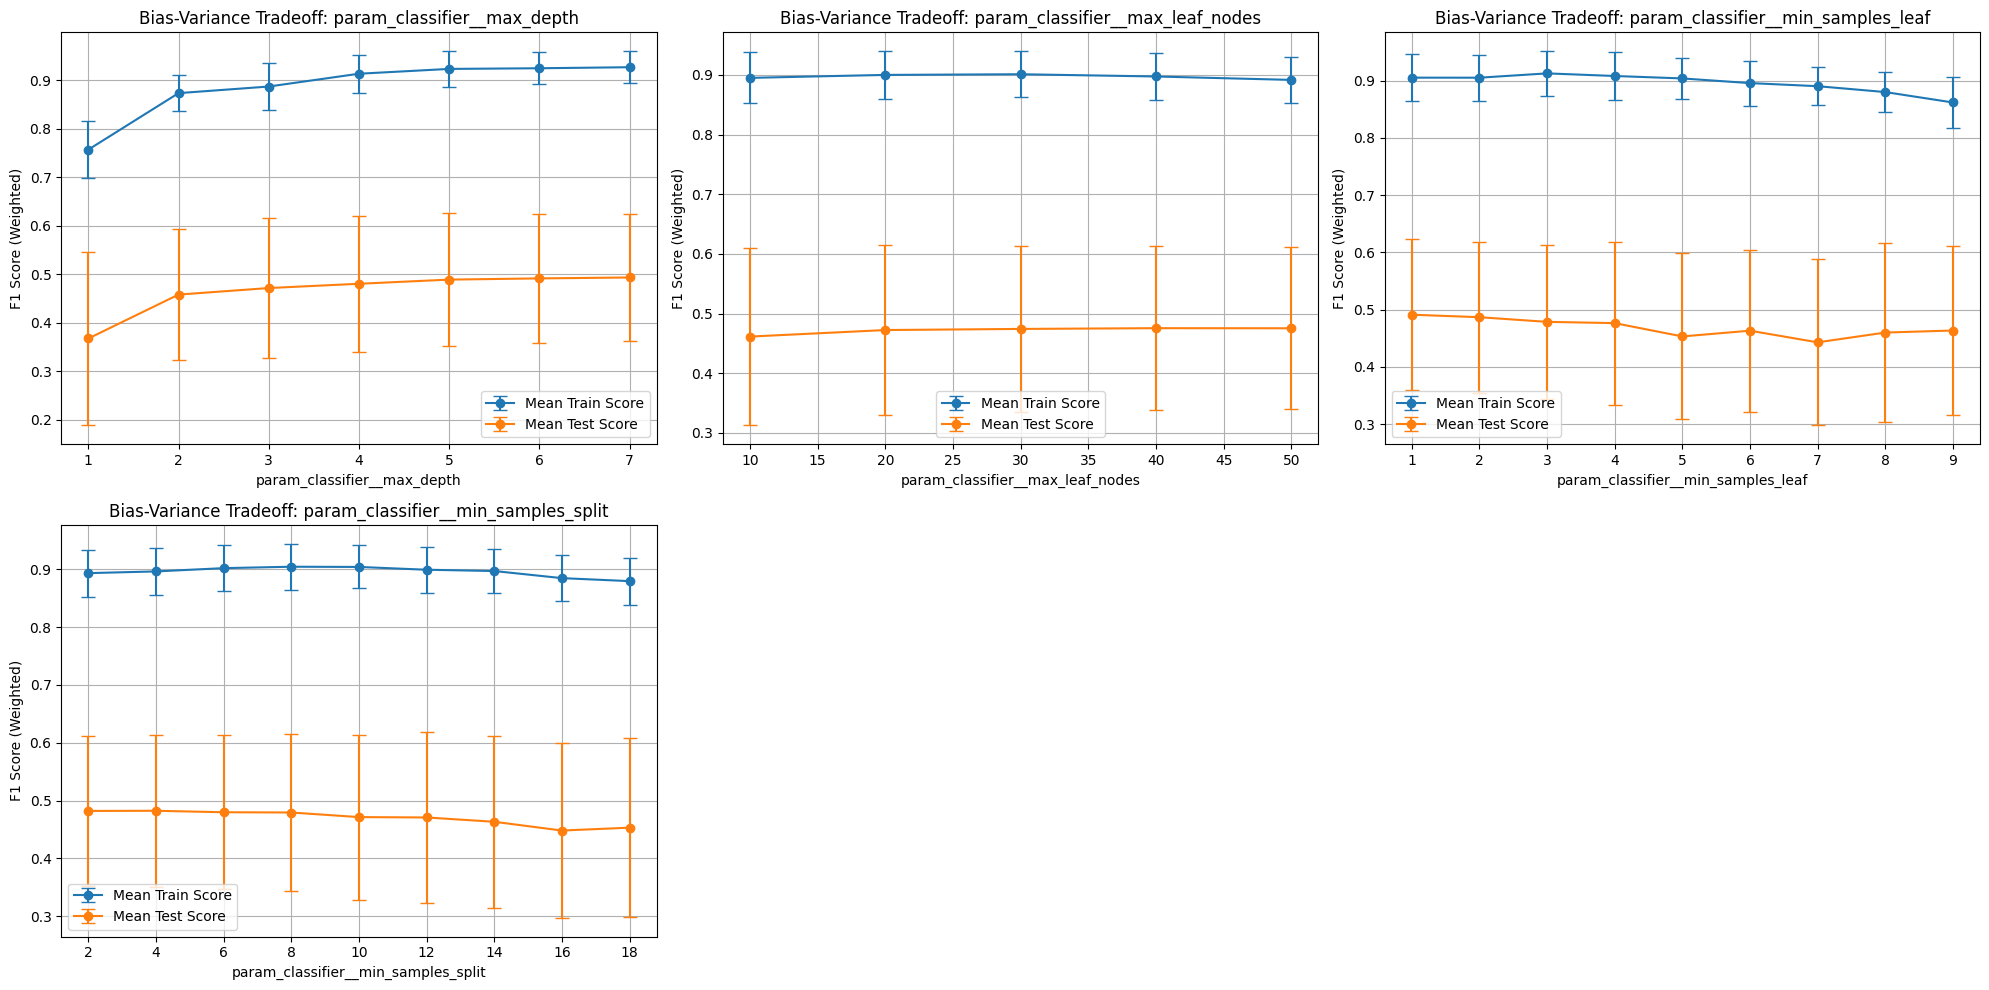

475792


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



Best RFC_balanced_subsample model for BINANCE - unified
CV results: dict_keys(['iter', 'n_resources', 'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classifier__max_depth', 'param_classifier__max_leaf_nodes', 'param_classifier__min_samples_leaf', 'param_classifier__min_samples_split', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])
CV results: 4253


KeyError: 'conf_matrix'

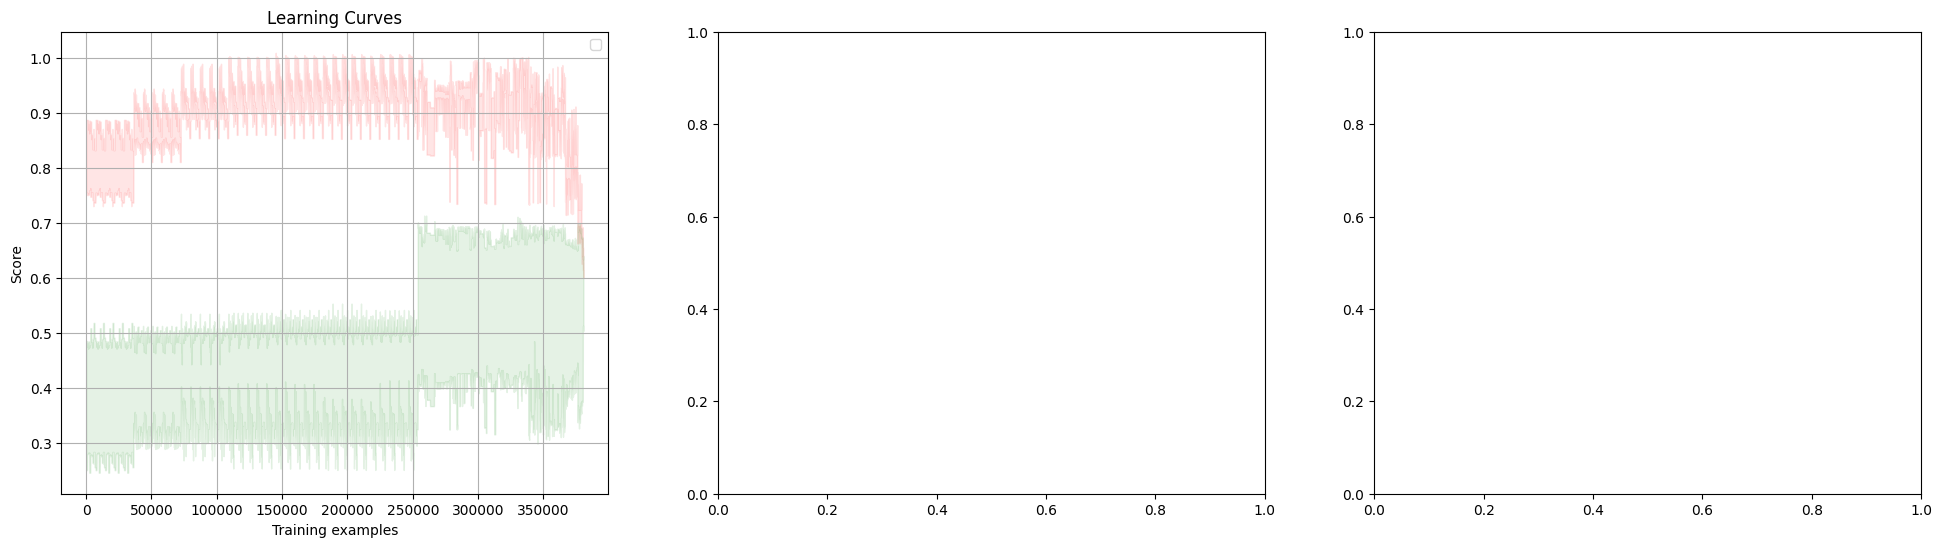

In [4]:
# Evaluation

for classifier_name, _ in classifiers.items():
        for exchange, data_type in product(EXCHANGES, DATA_TYPES):
                model_path = os.path.join(MODELS_DATA_PATH, f"{classifier_name}_{exchange}_{data_type}.pkl")
                
                if not os.path.exists(model_path):
                    continue

                with open(model_path, "rb") as model_file:
                            btcf = pickle.load(model_file)
                
                print(f"\nBest {classifier_name} model for {exchange} - {data_type}")

                # Plots
                filename_prefix = f"{classifier_name}_{exchange}_{data_type}"
                val_curve_param = 'classifier__max_depth'

                btcf.plot_learn_cm_feat(f"{filename_prefix}_learn_val_feat.png")
                btcf.plot_bias_variance_tradeoff(f"{filename_prefix}_bias_variance_tradeoff.png")
                print(len(btcf.X))

                del(btcf)
                gc.collect()

In [5]:
# Results

eval_results = []
t_test_data = []
comparison_data = []
t_test_metrics = ['mean_test_score', 'mean_train_score', 'std_test_score', 'std_train_score']

for classifier_name, _ in classifiers.items():
        for exchange, data_type in product(EXCHANGES, DATA_TYPES):
                
                model_path = os.path.join(MODELS_DATA_PATH, f"{classifier_name}_{exchange}_{data_type}.pkl")
                if not os.path.exists(model_path):
                    continue

                with open(model_path, "rb") as model_file:
                    btcf = pickle.load(model_file)

                eval_metrics = [x for x in btcf.results.keys() if x not in ['best_params', 'conf_matrix', 'cv_results', 'classification_report', 'feature_selection']]
                metrics_dict = {metric: btcf.results[metric] for metric in eval_metrics}
                eval_record = {
                    'classifier': classifier_name,
                    'exchange': exchange,
                    'data_type': data_type
                }
                
                eval_record.update(btcf.results['best_params'])  
                eval_record.update(metrics_dict)
                eval_results.append(eval_record)

                t_record = { metric: btcf.results['cv_results'][metric] for metric in t_test_metrics }
                t_record.update({'exchange': exchange, 'data_type': data_type, 'classifier': classifier_name })
                t_test_data.append(t_record)

                comparison_record = {**eval_record, **t_record}
                comparison_data.append(comparison_record)
                
                del(btcf)
                gc.collect()

results_df = pd.DataFrame(eval_results)
results_df.to_csv(os.path.join(REPORTS_PATH, 'results.csv'), index=False)
display(results_df)

data_types = results_df['data_type'].unique()
all_comparisons = pd.concat([compute_comparison(pd.DataFrame(comparison_data), data_type) for data_type in data_types], ignore_index=True)
display(all_comparisons)

ttest_results = pd.concat([perform_ttest(pd.DataFrame(t_test_data), metric) for metric in t_test_metrics], ignore_index=True)
display(ttest_results)

,classifier,exchange,data_type,classifier__max_depth,classifier__max_leaf_nodes,classifier__min_samples_leaf,classifier__min_samples_split,best_score,accuracy (balanced),precision (macro),recall (macro),fscore (macro),precision (weighted),recall (weighted),fscore (weighted)
0,RFC_balanced_subsample,BINANCE,candles,7,50,1,4,0.589712,0.424449,0.469540,0.424449,0.438092,0.744947,0.786855,0.762199
1,RFC_balanced_subsample,BINANCE,orderbook,6,50,1,6,0.445848,0.411394,0.387732,0.411394,0.390091,0.714509,0.632794,0.667408
2,RFC_balanced_subsample,BINANCE,unified,6,50,2,6,0.572102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,RFC_balanced_subsample,HUOBI,candles,7,50,3,2,0.451555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,RFC_balanced_subsample,HUOBI,orderbook,7,50,7,2,0.510198,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,RFC_balanced_subsample,HUOBI,unified,7,50,1,10,0.569970,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,RFC_balanced_subsample,OKX,candles,6,50,1,6,0.493045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,RFC_balanced_subsample,OKX,orderbook,7,50,2,8,0.456194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,RFC_balanced_subsample,OKX,unified,7,50,3,8,0.533161,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,data_type,exchange1,exchange2,exchange1_mean_lower,exchange1_mean_upper,exchange2_mean_lower,exchange2_mean_upper,mean_diff_lower,mean_diff_upper,exchange1_ci_percentage,exchange2_ci_percentage,mean_diff_ci_percentage
0,candles,BINANCE,HUOBI,0.526968,0.528790,0.483505,0.485169,0.042255,0.044695,0.345797,0.344203,5.772386
1,candles,BINANCE,OKX,0.526921,0.528696,0.464989,0.468069,0.059454,0.063151,0.336873,0.662405,6.217227
2,candles,HUOBI,OKX,0.483500,0.485214,0.464902,0.468101,0.015996,0.019634,0.354332,0.688185,22.743043
3,orderbook,BINANCE,HUOBI,0.470627,0.473215,0.461277,0.464291,0.007073,0.011238,0.549773,0.653417,58.876044
4,orderbook,BINANCE,OKX,0.470742,0.473244,0.548553,0.551265,-0.079742,-0.075989,0.531574,0.494416,4.705736
5,orderbook,HUOBI,OKX,0.461229,0.464326,0.548389,0.551305,-0.089121,-0.085060,0.671336,0.531627,4.556622
6,unified,BINANCE,HUOBI,0.448939,0.452833,0.514383,0.515789,-0.066291,-0.062132,0.867321,0.273273,6.274662
7,unified,BINANCE,OKX,0.449019,0.452807,0.527094,0.528967,-0.079239,-0.074976,0.843591,0.355343,5.379717
8,unified,HUOBI,OKX,0.514361,0.515746,0.527065,0.529050,-0.014243,-0.011844,0.269334,0.376637,16.838849


,data_type,exchange1,exchange2,metric,t_stat,p_value
0,candles,BINANCE,HUOBI,mean_test_score,67.085138,0.000000e+00
1,candles,BINANCE,OKX,mean_test_score,66.181712,0.000000e+00
2,candles,HUOBI,OKX,mean_test_score,19.638657,1.643051e-83
3,orderbook,BINANCE,HUOBI,mean_test_score,8.729772,3.053063e-18
4,orderbook,BINANCE,OKX,mean_test_score,-78.023068,0.000000e+00
5,orderbook,HUOBI,OKX,mean_test_score,-79.881086,0.000000e+00
6,unified,BINANCE,HUOBI,mean_test_score,-62.862408,0.000000e+00
7,unified,BINANCE,OKX,mean_test_score,-71.403907,0.000000e+00
8,unified,HUOBI,OKX,mean_test_score,-20.827578,8.996234e-94
9,candles,BINANCE,HUOBI,mean_train_score,-26.673936,1.427331e-150
